# SVM Model

## Imports

In [40]:
import json
import os
import cv2
import numpy as np
from sklearn.svm import SVR, SVC
from skimage.feature import hog
import PIL
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, average_precision_score

# CONSTANTS
IMG_WIDTH = 512
IMG_HEIGHT= 512
CLASSES = ['dent', 'scrath', 'crack', 'glass shatter', 'lamp broken', 'tire flat']

## Data Loading and Preprocessing

In [35]:
def get_data(image_path, labels_path, img_width=512, img_height=512):
    # Get the image files
    images = []
    for file in os.listdir(image_path):
        image = cv2.imread(os.path.join(image_path, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Ensure it is RGB
        image = cv2.resize(image, (img_width, img_height))
        image = hog(image ,orientations=9,pixels_per_cell=(16,16), # TODO: Look into exatly what this is doing
              cells_per_block=(2,2), channel_axis=2)
        images.append(image)
        
    image_array = np.array(images)

    # Get the labels
    with(open(labels_path)) as label_data:
        annot_df = json.load(label_data)
        
    labels = {
        "classification": {}, # Store image id and list of labels for that image
        'bbox' : {},
        'segementation' : {}
    }
    for annotations in annot_df['annotations']:
        image_id = annotations['image_id']
        
        # Classification
        if(image_id in labels['classification'].keys()):
            labels['classification'][image_id].append(annotations['category_id'])
        else:
            labels['classification'][image_id] = [annotations['category_id']]
            
        # Bounding Box
        if(image_id in labels['bbox'].keys()):
            labels['bbox'][image_id].append(annotations['bbox'])
        else:
            labels['bbox'][image_id] = [annotations['bbox']]
        
        # Segmentation
        if(image_id in labels['segementation'].keys()):
            labels['segementation'][image_id].append(annotations['segmentation'])
        else:
            labels['segementation'][image_id] = [annotations['segmentation']]
    
    # Return the images and associated labels
    return image_array, labels

In [36]:
Xtrain, ytrain = get_data(image_path='../data/images/train', labels_path='../data/images/annotations/train.json', img_width=IMG_WIDTH, img_height=IMG_HEIGHT)
Xtest, ytest = get_data(image_path='../data/images/test', labels_path='../data/images/annotations/test.json', img_width=IMG_WIDTH, img_height=IMG_HEIGHT)

print("Xtrain Shape: ", Xtrain.shape)
print("Xtest Shape: ", Xtest.shape)

Xtrain Shape:  (2816, 34596)
Xtest Shape:  (374, 34596)


In [66]:
dent_images = []
scratch_images = []
crack_images = []
glass_shatter_images = []
lamp_broken_images = []
tire_flat_images = []

# Create a list of images for each category
for i, image in enumerate(Xtrain):
    if(i + 1 not in ytrain['classification'].keys()):
        continue
    
    if(CLASSES.index('dent') + 1 in ytrain['classification'][i + 1]):
        dent_images.append(image)
    if(CLASSES.index('scrath') + 1 in ytrain['classification'][i + 1]):
        scratch_images.append(image)
    if(CLASSES.index('crack') + 1 in ytrain['classification'][i + 1]):
        crack_images.append(image)
    if(CLASSES.index('glass shatter') + 1 in ytrain['classification'][i + 1]):
        glass_shatter_images.append(image)
    if(CLASSES.index('lamp broken') + 1 in ytrain['classification'][i + 1]):
        lamp_broken_images.append(image)
    if(CLASSES.index('tire flat') + 1 in ytrain['classification'][i + 1]):
        tire_flat_images.append(image)

Xtrain_c = np.concatenate((dent_images, scratch_images, crack_images, glass_shatter_images, lamp_broken_images, tire_flat_images))
ytrain_c = np.concatenate((np.ones(len(dent_images)), np.ones(len(scratch_images)) * 2, np.ones(len(crack_images)) * 3, np.ones(len(glass_shatter_images)) * 4, np.ones(len(lamp_broken_images)) * 5, np.ones(len(tire_flat_images)) * 6))

In [67]:
dent_images = []
scratch_images = []
crack_images = []
glass_shatter_images = []
lamp_broken_images = []
tire_flat_images = []

# Create a list of images for each category
for i, image in enumerate(Xtest):
    if(i + 1 not in ytest['classification'].keys()):
        continue
    
    if(CLASSES.index('dent') + 1 in ytest['classification'][i + 1]):
        dent_images.append(image)
    if(CLASSES.index('scrath') + 1 in ytest['classification'][i + 1]):
        scratch_images.append(image)
    if(CLASSES.index('crack') + 1 in ytest['classification'][i + 1]):
        crack_images.append(image)
    if(CLASSES.index('glass shatter') + 1 in ytest['classification'][i + 1]):
        glass_shatter_images.append(image)
    if(CLASSES.index('lamp broken') + 1 in ytest['classification'][i + 1]):
        lamp_broken_images.append(image)
    if(CLASSES.index('tire flat') + 1 in ytest['classification'][i + 1]):
        tire_flat_images.append(image)

Xtest_c = np.concatenate((dent_images, scratch_images, crack_images, glass_shatter_images, lamp_broken_images, tire_flat_images))
ytest_c = np.concatenate((np.ones(len(dent_images)), np.ones(len(scratch_images)) * 2, np.ones(len(crack_images)) * 3, np.ones(len(glass_shatter_images)) * 4, np.ones(len(lamp_broken_images)) * 5, np.ones(len(tire_flat_images)) * 6))

In [68]:
model = SVC()

model.fit(Xtrain_c, ytrain_c)
y_pred = model.predict(Xtest_c)

print("Accuracy: ", accuracy_score(ytest_c, y_pred))

Accuracy:  0.17647058823529413


## Sliding Window Functionality

In [69]:
# Adapted from https://www.kaggle.com/code/mehmetlaudatekman/support-vector-machine-object-detection
def slideExtract(image, windowSize=(512, 512), step=12):
    
    # Converting to grayscale
    img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    # We'll store coords and features in these lists
    coords = []
    features = []
    
    hIm,wIm = image.shape[:2] 

    
    # W1 will start from 0 to end of image - window size
    # W2 will start from window size to end of image
    # We'll use step (stride) like convolution kernels.
    for w1,w2 in zip(range(0,wIm-windowSize[0],step),range(windowSize[0],wIm,step)):
       
        for h1,h2 in zip(range(0,hIm-windowSize[1],step),range(windowSize[1],hIm,step)):
            window = img[h1:h2,w1:w2]
            features_of_window = hog(window,orientations=9,pixels_per_cell=(16,16),
                                     cells_per_block=(2,2)
                                    )
            
            coords.append((w1,w2,h1,h2))
            features.append(features_of_window)
    
    return (coords,np.asarray(features))

# Modeling

In [72]:
example_image = np.asarray(PIL.Image.open("../data/images/train/000001.jpg"))
coords,features = slideExtract(example_image)

coords[:5]

[(0, 512, 0, 512),
 (0, 512, 12, 524),
 (0, 512, 24, 536),
 (0, 512, 36, 548),
 (0, 512, 48, 560)]

In [73]:
from sklearn.preprocessing import MinMaxScaler

class Heatmap():
    
    def __init__(self,original_image):
        
        # Mask attribute is the heatmap initialized with zeros
        self.mask = np.zeros(original_image.shape[:2])
    
    # Increase value of region function will add some heat to heatmap
    def incValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] + 30
    
    # Decrease value of region function will remove some heat from heatmap
    # We'll use this function if a region considered negative
    def decValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] - 30
    
    def compileHeatmap(self):
        
        # As you know,pixel values must be between 0 and 255 (uint8)
        # Now we'll scale our values between 0 and 255 and convert it to uint8
        
        # Scaling between 0 and 1 
        scaler = MinMaxScaler()
        
        self.mask = scaler.fit_transform(self.mask)
        
        
        # Scaling between 0 and 255
        self.mask = np.asarray(self.mask * 255).astype(np.uint8)
        
        # Now we'll threshold our mask, if a value is higher than 170, it will be white else
        # it will be black
        self.mask = cv2.inRange(self.mask,170,255)
        
        return self.mask

In [74]:
def detect(image, model):
    
    # Extracting features and initalizing heatmap
    coords,features = slideExtract(image)
    htmp = Heatmap(image)
    
    
    for i in range(len(features)):
        # If region is positive then add some heat
        decision = model.predict([features[i]])
        if decision[0] == 1:
            htmp.incValOfReg(coords[i])
            # Else remove some heat
        else:
            htmp.decValOfReg(coords[i])
    
    # Compiling heatmap
    mask = htmp.compileHeatmap()
    
    cont,_ = cv2.findContours(mask,1,2)[:2]
    for c in cont:
        # If a contour is small don't consider it
        if cv2.contourArea(c) < 70*70:
            continue
        
        (x,y,w,h) = cv2.boundingRect(c)
        image = cv2.rectangle(image,(x,y),(x+w,y+h),(255),2)
    
    return image

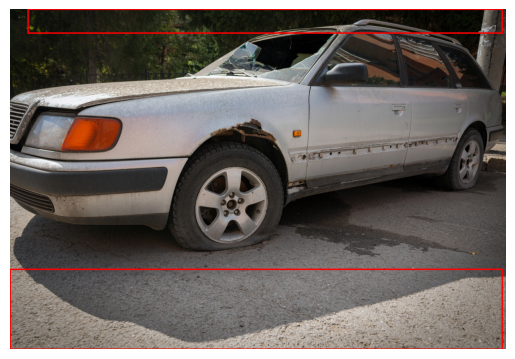

In [76]:
img = np.asarray(PIL.Image.open('../data/images/val/000013.jpg'))

detected = detect(img, model)
plt.imshow(detected)
plt.axis("off")
plt.show()

In [ ]:
img = np.asarray(PIL.Image.open('../data/images/val/000016.jpg'))

detected = detect(img, model)
plt.imshow(detected)
plt.axis("off")
plt.show()

In [ ]:
img = np.asarray(PIL.Image.open('../data/images/val/000017.jpg'))

detected = detect(img, model)
plt.imshow(detected)
plt.axis("off")
plt.show()

In [ ]:
img = np.asarray(PIL.Image.open('../data/images/val/000024.jpg'))

detected = detect(img, model)
plt.imshow(detected)
plt.axis("off")
plt.show()